In [17]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation as R

import sys
sys.path.append('D:/Final qualifying work/main') 
sys.path.append('D:/Final qualifying work/main/source') 

from source.core import Camera
from source.calibration import VanishingPointEstimator, VanishingPointCalibration

%matplotlib inline

In [18]:
def load_lines(filename):
    _filename = os.path.join("vp", filename)
    if not os.path.exists(_filename):
        print("Файл аннотаций не найден.")
        return

    with open(_filename, "r") as f:
        data = json.load(f)

    # Преобразуем строки ключей обратно в список линий
    lines = [[tuple(point) for point in line] for line in data.values()]
    return lines

In [19]:
def draw_coordinate_axes_from_vps(vanishing_points, center, scale=100, labels=None, colors=None, flip_z=True):
    """
    Рисует координатные оси X, Y, Z от центра изображения по направлению к точкам схода.

    :param vanishing_points: список [(x1, y1), (x2, y2), (x3, y3)] — координаты VP
    :param center: (cx, cy) — центр изображения (или центр проекции камеры)
    :param scale: длина стрелок (в пикселях)
    :param labels: подписи осей, по умолчанию ['X', 'Y', 'Z']
    :param colors: цвета осей, по умолчанию ['red', 'green', 'blue']
    """
    if labels is None:
        labels = ['X', 'Y', 'Z']
    if colors is None:
        colors = ['red', 'green', 'blue']

    cx, cy = center

    for i, (x, y) in enumerate(vanishing_points):
        dx = x - cx
        dy = y - cy
        norm = np.hypot(dx, dy)
        dx_scaled = dx / norm * scale
        dy_scaled = dy / norm * scale

        if flip_z and labels[i].upper() == 'Z':
            dx_scaled *= -1
            dy_scaled *= -1

        # Рисуем стрелку оси
        plt.arrow(cx, cy, dx_scaled, dy_scaled,
                  color=colors[i], width=1.2, head_width=10, length_includes_head=True)


In [20]:
lines_vp1 = load_lines("vp1.json")
lines_vp2 = load_lines("vp2.json")
lines_vp3 = load_lines("vp3.json")

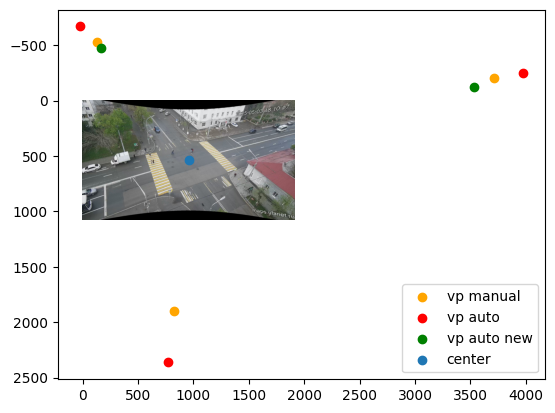

In [21]:
image = cv2.imread('image/pattern_corrected_image.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

vp1_manual = VanishingPointEstimator().estimate(lines_vp1)
vp2_manual = VanishingPointEstimator().estimate(lines_vp2)
vp3_manual = VanishingPointEstimator().estimate(lines_vp3)

vps_manual = np.array([vp1_manual, vp3_manual,vp2_manual])

plt.scatter(vps_manual[:,0],vps_manual[:,1], label='vp manual', c='orange')

vp1 = [3974.185, -248.69977]
vp2 = [768.4042, 2362.912]
vp3 = [-24.940735, -669.0249]

vp1_new = [ 3.535e+03, -1.270e+02]
vp2_new = [164.36434109, -476.74418605]

vps_auto = np.array([vp1, vp3, vp2])
vps_auto_new = np.array([vp1_new,vp2_new])
plt.scatter(vps_auto[:,0],vps_auto[:,1], label='vp auto', c='red')
plt.scatter(vps_auto_new[:,0],vps_auto_new[:,1], label='vp auto new', c='green')
# plt.scatter(VP[:,0],VP[:,1], label='vp auto new', c='yellow')

plt.scatter(960,540, label = 'center')

plt.legend()


# Ручная разметка

In [22]:
camera = Camera('image/pattern_corrected_image.png')
calibrationVP = VanishingPointCalibration(camera)
calibrationVP.set_vanishing_points(*vps_manual)
f = calibrationVP.calc_f()
print(f'Фокусное расстояние: {f}')
matrix_R = np.array(calibrationVP.calc_R(f))
print(f'Rot:\n{matrix_R}')

Фокусное расстояние: 1179.0746221290515
Rot:
[[ 0.89223005 -0.44636264  0.0684538 ]
 [-0.2410857  -0.59900726 -0.76358888]
 [ 0.38184188  0.66479372 -0.64206393]]


In [25]:
print("Ортонормальность:")
print("r1·r2 =", np.dot(matrix_R[:, 0], matrix_R[:, 1]))
print("r1·r3 =", np.dot(matrix_R[:, 0], matrix_R[:, 2]))
print("r2·r3 =", np.dot(matrix_R[:, 1], matrix_R[:, 2]))

print("det(R) =", np.linalg.det(matrix_R))

Ортонормальность:
r1·r2 = 9.818858443085795e-18
r1·r3 = -2.5037604244158657e-17
r2·r3 = 6.303756414389777e-17
det(R) = 0.9999999999999997


In [28]:
r = R.from_matrix(matrix_R)

In [34]:
euler_angles = r.as_euler('zxy', degrees=True)
euler_angles

array([-158.07642684,   49.78161572,  173.91438536])

# С известным фокусным расстоянием через lu_vp_detect

In [35]:
calibrationVP.set_vanishing_points(*vps_auto)
f = calibrationVP.calc_f()
print(f'Фокусное расстояние: {f}')
matrix_R = np.array(calibrationVP.calc_R(f))
print(f'Rot:\n{matrix_R}')

Фокусное расстояние: 1419.5898920298214
Rot:
[[ 0.88035542 -0.46705963  0.08264159]
 [-0.23035617 -0.5733206  -0.78628209]
 [ 0.41462075  0.6731707  -0.61231596]]


In [37]:
print("Ортонормальность:")
print("r1·r2 =", np.dot(matrix_R[:, 0], matrix_R[:, 1]))
print("r1·r3 =", np.dot(matrix_R[:, 0], matrix_R[:, 2]))
print("r2·r3 =", np.dot(matrix_R[:, 1], matrix_R[:, 2]))

print("det(R) =", np.linalg.det(matrix_R))

Ортонормальность:
r1·r2 = -1.3072839100797671e-17
r1·r3 = -2.021754334744414e-18
r2·r3 = -3.898298473142301e-17
det(R) = 1.0000000000000002


In [38]:
r = R.from_matrix(matrix_R)
euler_angles = r.as_euler('zxy', degrees=True)
euler_angles

array([-158.11008652,   51.83941195,  172.31348779])

# Через RANSAK

In [39]:
calibrationVP.set_vanishing_points(vps_auto_new[0],vpZ=vps_auto_new[1])
f = calibrationVP.calc_f()
print(f'Фокусное расстояние: {f}')
matrix_R = np.array(calibrationVP.calc_R(f))
print(f'Rot:\n{matrix_R}')

Фокусное расстояние: 1170.7234727286798
Rot:
[[ 0.88603103 -0.44984492  0.11219877]
 [-0.22950784 -0.63584342 -0.73690521]
 [ 0.40283391  0.62717039 -0.66661994]]


In [40]:
print("Ортонормальность:")
print("r1·r2 =", np.dot(matrix_R[:, 0], matrix_R[:, 1]))
print("r1·r3 =", np.dot(matrix_R[:, 0], matrix_R[:, 2]))
print("r2·r3 =", np.dot(matrix_R[:, 1], matrix_R[:, 2]))

print("det(R) =", np.linalg.det(matrix_R))

Ортонормальность:
r1·r2 = -3.006188555731325e-17
r1·r3 = -9.968229523146553e-18
r2·r3 = 1.8228034349437923e-17
det(R) = 1.0000000000000002


In [41]:
r = R.from_matrix(matrix_R)
euler_angles = r.as_euler('zxy', degrees=True)
euler_angles

array([-160.15293937,   47.46845015,  170.4460936 ])

# Ориентация камеры через точки схода

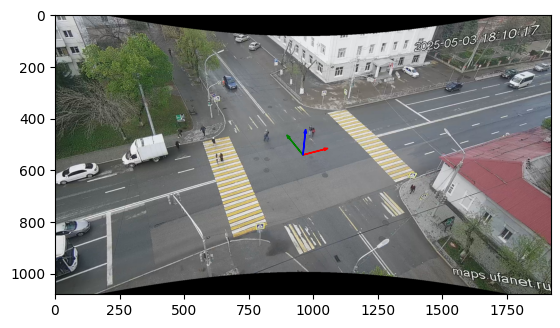

In [42]:
center = (960,540)
plt.imshow(image_rgb)
draw_coordinate_axes_from_vps(vps_auto,center)

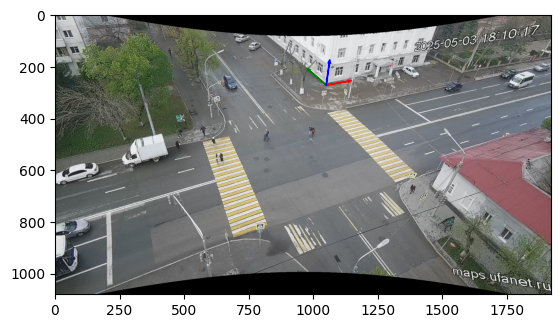

In [43]:
center = (1050,270)
plt.imshow(image_rgb)
draw_coordinate_axes_from_vps(vps_manual,center)

# Иной подход

In [44]:
K = camera.intrinsics.get()
print(f'Внутренние параметры камеры:\n{K}')

Внутренние параметры камеры:
[[1.17072347e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 1.17072347e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [46]:
VP = []
for i in range(3):
    vp = K @ matrix_R[:, i]
    vp = vp[:2]/vp[-1]
    VP.append(vp)
VP = np.array(VP)
print(f'VP:\n{VP}')

VP:
[[3535.         -127.        ]
 [ 120.28560659 -646.91321356]
 [ 762.95558752 1834.15905169]]


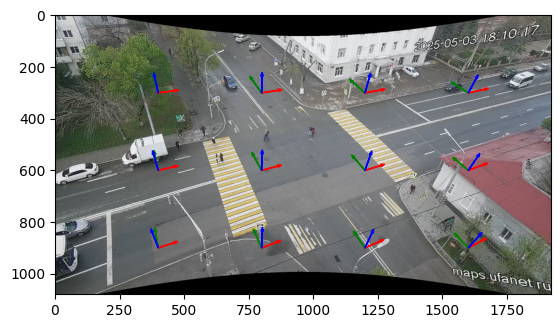

In [50]:

h, w = image.shape[:2]
step_x = 400
step_y = 300

centers = [
    (int(x), int(y))
    for y in np.arange(step_y, h, step_y)
    for x in np.arange(step_x, w, step_x)
]

plt.imshow(image_rgb)
for center in centers:
    draw_coordinate_axes_from_vps(VP,center,scale=80)